<a href="https://colab.research.google.com/github/Gatuha/electricity-demard-forecast-in-kenya/blob/main/electricity_demand_forecast_in_kenya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

Welcome to my time series forecasting kernel, focused on predicting electricity demand in Kenya using historical data from the Africa National Grid. In this project, I will systematically approach the task by following the next steps:

    Performing EDA and Feature Engineering: The first stage involves exploratory data analysis (EDA) to better understand the dataset, clean it, and create new features that can enhance our predictive models. This phase will also help us uncover any underlying trends and seasonality in the electricity demand data.

    Utilizing SARIMA Models: In this phase, I will employ Seasonal Autoregressive Integrated Moving Average (SARIMA) models to predict electricity demand. To build an effective SARIMA model, we will need to examine the data's variations and conduct additional EDA to estimate the model parameters accurately.

    Employing XGBoost Models: As an alternative approach, we will leverage XGBoost models to predict electricity demand. This machine learning-based model can capture complex relationships in the data and potentially improve prediction accuracy.


In [6]:
!pip install pmdarima
!pip install workalendar
!pip install prophet
!pip install -q --upgrade linear-tree

In [8]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.africa import kenya

In [10]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize


In this notebook, I will generate multiple figures. To streamline the process and eliminate the need to configure settings individually for each plot, I will establish a consistent default font and font size to be applied universally across all plots.

In [11]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

##Load data
I used the National Grid API to acess the historic electricity demand between 2009 and 2022

In [15]:
df = pd.read_csv("/content/drive/MyDrive/dataset/electricity_demand.csv", index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

##Exploratory Data Analysis and feature engineering
    Data Understanding: Initial exploration of the time series dataset.
    Data Preparation: Handling null values, eliminating uninformative features, and addressing outliers.
    Feature Understanding: Identifying trends and various seasonal patterns in the data.

For this project, I'll focus on three key columns from the dataset:

    SETTLEMENT_DATE: Date in the format dd/mm/yyyy.
    SETTLEMENT_PERIOD: Half-hourly periods for historical outturn occurrences.
    TSD (Transmission System Demand): This represents the Transmission System Demand, which is equal to the ND plus the additional generation required to meet station load, pump storage pumping, and interconnector exports, measured in MW.

The target variable is TSD, and the goal is to predict future demand using various models.

In [16]:
df.describe()

settlement_period             nd            tsd         demand  \
count      154502.000000  154502.000000  154502.000000  154502.000000   
mean           24.491922   31592.213007   32996.364299   28738.429308   
std            13.863640    7829.974659    7737.665451    7099.947483   
min             1.000000   13367.000000       0.000000       0.000000   
25%            12.000000   25320.000000   26959.250000   23030.000000   
50%            24.000000   30961.000000   32188.000000   28158.000000   
75%            37.000000   37364.000000   38520.000000   34010.000000   
max            50.000000   59095.000000   60147.000000   53325.000000   

       embedded_wind_generation  embedded_wind_capacity  \
count             154502.000000           154502.000000   
mean                1213.813575             4266.089261   
std                  920.044747             1935.620649   
min                    0.000000             1403.000000   
25%                  528.000000             2085.000000   
50%                  976.000000             4253.000000   
75%                 1647.000000             6465.000000   
max                 5354.000000             6574.000000   

       embedded_solar_generation  embedded_solar_capacity    non_bm_stor  \
count              154502.000000            154502.000000  154502.000000   
mean                  827.385005              7936.738075       7.258171   
std                  1635.080595              5537.146507      40.959974   
min                     0.000000                 0.000000     -24.000000   
25%                     0.000000              1858.000000       0.000000   
50%                     0.000000              9602.000000       0.000000   
75%                   788.000000             13080.000000       0.000000   
max                  9830.000000             14285.000000     893.000000   

       pump_storage_pumping       ifa_flow      ifa2_flow   britned_flow  \
count         154502.000000  154502.000000  154502.000000  154502.000000   
mean             315.273039     915.365814      21.867529     532.548329   
std              540.689849    1087.272109     319.609352     518.517754   
min                0.000000   -2056.000000   -1030.000000   -1215.000000   
25%                8.000000     211.000000       0.000000       0.000000   
50%               11.000000    1207.000000       0.000000     759.000000   
75%              415.750000    1897.000000       0.000000     994.000000   
max             2019.000000    2066.000000    1016.000000    1143.000000   

          moyle_flow  east_west_flow      nemo_flow      nsl_flow  \
count  154502.000000   154502.000000  154502.000000  49231.000000   
mean     -112.566789      -30.970732     152.475994    256.226361   
std       224.943060      252.393642     394.643742    545.903622   
min      -505.000000     -585.000000   -1022.000000  -1455.000000   
25%      -254.000000     -146.000000       0.000000      0.000000   
50%      -127.000000        0.000000       0.000000      0.000000   
75%        39.000000        0.000000       0.000000    693.000000   
max       499.000000      504.000000    1033.000000   1401.000000   

       eleclink_flow     is_holiday  kenyan_bank_holiday  
count   49231.000000  154502.000000        154502.000000  
mean      -14.727265       0.022938             0.029695  
std       400.055077       0.149707             0.169746  
min     -1026.000000       0.000000             0.000000  
25%         0.000000       0.000000             0.000000  
50%         0.000000       0.000000             0.000000  
75%         0.000000       0.000000             0.000000  
max      1002.000000       1.000000             1.000000

In [17]:
df.shape

(154502, 23)

In [18]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

##Data Preparation

In this section, our objective is to prepare the data for modeling. To achieve this, we will take the following steps:

    Identify and remove columns with missing values.
    Eliminate rows where the settlement_period exceeds 48, as per the API's maximum allowable samples per day.
    Address outliers.

# New Section

In [19]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
demand                       False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
is_holiday                   False
country                      False
town                         False
kenyan_bank_holiday          False
dtype: bool

 only two columns include nan values. Let's check how many nan values there are in each column

In [20]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

nsl_flow  eleclink_flow
True     105271         105271
False     49231          49231

 both features have the same number of nan values. Let's look at that the dataframe containing the nan value:

In [21]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

settlement_date  settlement_period     nd    tsd  demand  \
0             01-01-09                  1  37910  38704   33939   
1             01-01-09                  2  38047  38964   34072   
2             01-01-09                  3  37380  38651   33615   
3             01-01-09                  4  36426  37775   32526   
4             01-01-09                  6  35408  37135   31604   
...                ...                ...    ...    ...     ...   
154387        31-12-18                 42  29357  30941   27501   
154388        31-12-18                 43  28020  29590   26303   
154389        31-12-18                 44  26826  28428   25195   
154390        31-12-18                 45  25660  27542   24145   
154391        31-12-18                 47  24188  26224   22683   

        embedded_wind_generation  embedded_wind_capacity  \
0                             54                    1403   
1                             53                    1403   
2                             53                    1403   
3                             50                    1403   
4                             43                    1403   
...                          ...                     ...   
154387                      2738                    5918   
154388                      2736                    5918   
154389                      2734                    5918   
154390                      2730                    5918   
154391                      2673                    5918   

        embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
0                               0                        0            0  ...   
1                               0                        0            0  ...   
2                               0                        0            0  ...   
3                               0                        0            0  ...   
4                               0                        0            0  ...   
...                           ...                      ...          ...  ...   
154387                          0                    13052            0  ...   
154388                          0                    13052            0  ...   
154389                          0                    13052            0  ...   
154390                          0                    13052            0  ...   
154391                          0                    13052            0  ...   

        britned_flow  moyle_flow  east_west_flow  nemo_flow  nsl_flow  \
0                  0        -161               0          0       NaN   
1                  0        -160               0          0       NaN   
2                  0        -160               0          0       NaN   
3                  0        -160               0          0       NaN   
4                  0        -160               0          0       NaN   
...              ...         ...             ...        ...       ...   
154387           716        -439            -536          0       NaN   
154388           862        -424            -536          0       NaN   
154389           777        -454            -535          0       NaN   
154390          -268        -455            -536          0       NaN   
154391          -467        -454            -466          0       NaN   

        eleclink_flow  is_holiday  country     town  kenyan_bank_holiday  
0                 NaN           1    Kenya    Thika                    1  
1                 NaN           1    Kenya   Nakuru                    1  
2                 NaN           1    Kenya    Thika                    1  
3                 NaN           1    Kenya  Eldoret                    1  
4                 NaN           1    Kenya   Nakuru                    1  
...               ...         ...      ...      ...                  ...  
154387            NaN           0    Kenya  Nairobi                    0  
154388            NaN           0    Kenya 

It appears that neither feature was present in the dataset between 2009 and 2018. To maintain data consistency, I will remove these features. Additionally, I will exclude rows where the `settlement_period` exceeds 48, as values beyond 48 indicate data logging errors.

In [22]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

Extracting the bank holidays and store them in the right format.

It's worth noting that this package includes the original bank holiday and when it was observed. I will only store the observed days

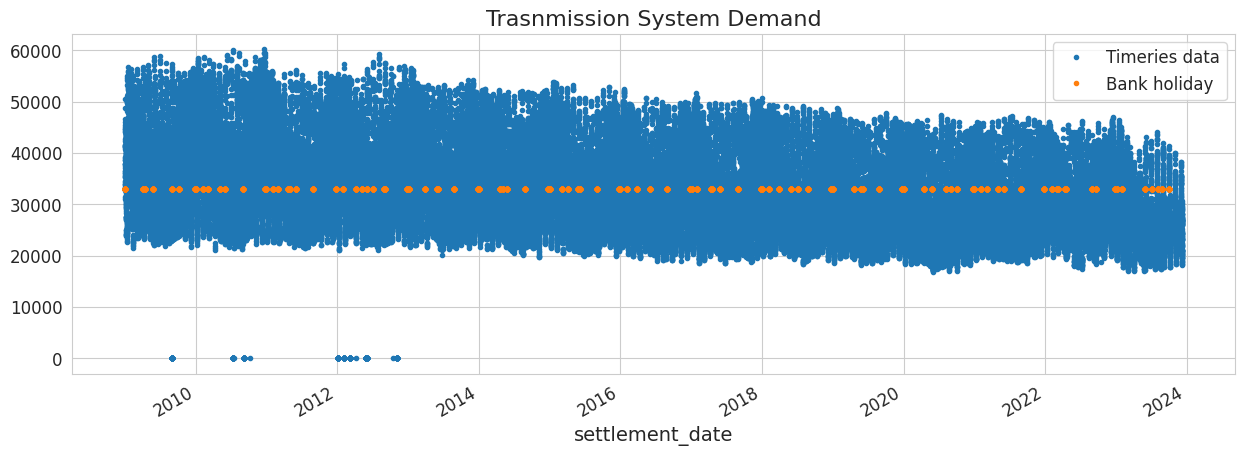

In [30]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

This plot displays our time series data's decreasing trend and annual seasonality. Notably, it highlights some zero values that we'll remove subsequently. While this graph reveals a yearly pattern, it doesn't allow for a daily or weekly focus. Thus, we'll create another plot to zoom in on a single week's data.

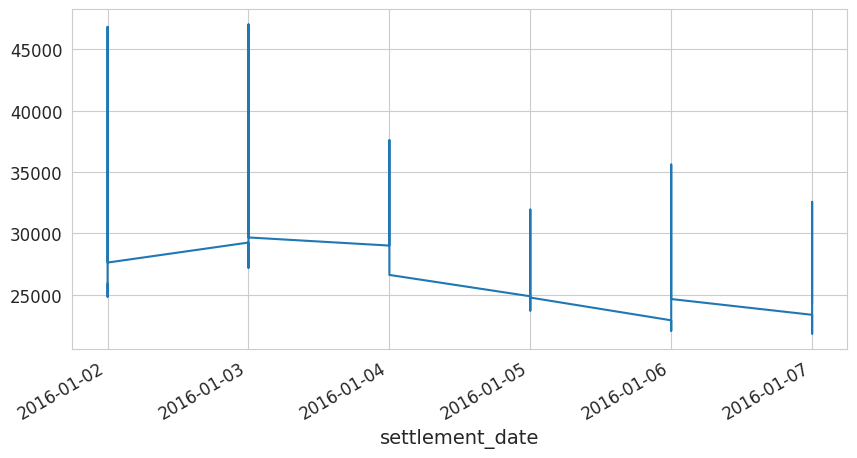

In [31]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

In [32]:
df_plot.head()

settlement_period     nd    tsd  demand  \
settlement_date                                            
2009-01-01                       1  37910  38704   33939   
2009-01-01                       2  38047  38964   34072   
2009-01-01                       3  37380  38651   33615   
2009-01-01                       4  36426  37775   32526   
2009-01-01                       6  35408  37135   31604   

                 embedded_wind_generation  embedded_wind_capacity  \
settlement_date                                                     
2009-01-01                             54                    1403   
2009-01-01                             53                    1403   
2009-01-01                             53                    1403   
2009-01-01                             50                    1403   
2009-01-01                             43                    1403   

                 embedded_solar_generation  embedded_solar_capacity  \
settlement_date                                                       
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   
2009-01-01                               0                        0   

                 non_bm_stor  pump_storage_pumping  ifa_flow  ifa2_flow  \
settlement_date                                                           
2009-01-01                 0                    33      2002          0   
2009-01-01                 0                   157      2002          0   
2009-01-01                 0                   511      2002          0   
2009-01-01                 0                   589      1772          0   
2009-01-01                 0                   967      1754          0   

                 britned_flow  moyle_flow  east_west_flow  nemo_flow  \
settlement_date                                                        
2009-01-01                  0        -161               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   
2009-01-01                  0        -160               0          0   

                 is_holiday country     town  kenyan_bank_holiday  
settlement_date                                                    
2009-01-01                1   Kenya    Thika                    1  
2009-01-01                1   Kenya   Nakuru                    1  
2009-01-01                1   Kenya    Thika                    1  
2009-01-01                1   Kenya  Eldoret                    1  
2009-01-01                1   Kenya   Nakuru                    1

This graph provides valuable insights into our time-series data, illustrating a decreasing trend alongside notable yearly patterns. However, zero-value data points are also evident, which will be addressed shortly. Upcoming steps involve:

    Outliers removal.
    Merging the hour with the date, followed by assigning it as the index.

## Outliers removal.

creating a histogram that will show outliers which are equal to zero


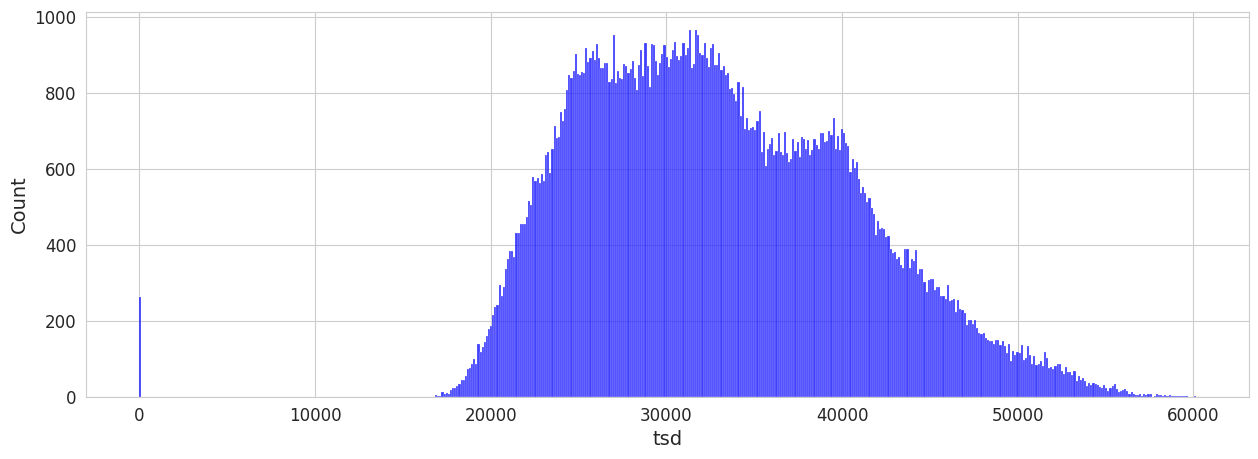

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

In order to maintain daily representativeness in our SARIMA models, I'll remove whole days with any zero values, moving beyond just eliminating zero-data points.


In [35]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

settlement_date  settlement_period period_hour     nd    tsd  demand  \
9744          02-12-10                 26    12:30:00  52483  54248   47471   
9886          02-12-15                 24    11:30:00  38614  40520   35207   
69085         14-07-20                 43    21:00:00  27413  29312   25001   
87349         18-03-13                 36    17:30:00  48281  49145   44039   
101371        20-12-14                 43    21:00:00  36601  37616   33355   
86197         17-12-17                 30    14:30:00  38655  39443   36080   
17219         04-05-18                 21    10:00:00  31983  32816   29094   

        embedded_wind_generation  embedded_wind_capacity  \
9744                        1142                    2141   
9886                        2786                    4013   
69085                        730                    6527   
87349                        564                    2113   
101371                      1071                    4039   
86197                       2978                    5754   
17219                       1016                    5859   

        embedded_solar_generation  embedded_solar_capacity  ...  ifa_flow  \
9744                            6                       69  ...      -752   
9886                         1380                     9063  ...      -690   
69085                           2                    13080  ...     -1388   
87349                          76                     2560  ...       491   
101371                          0                     5960  ...      1996   
86197                          93                    12916  ...      1494   
17219                        4420                    13052  ...      1494   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
9744            0             0        -399               0          0   
9886            0          1024        -211            -399          0   
69085           0            85         401             504         -3   
87349           0          1002        -251               0          0   
101371          0           985         -94            -301          0   
86197           0           998        -181             148          0   
17219           0          1002        -331               0          0   

        is_holiday  country     town kenyan_bank_holiday  
9744             0    Kenya    Thika                   0  
9886             0    Kenya  Nairobi                   0  
69085            0    Kenya  Eldoret                   0  
87349            0    Kenya   Nakuru                   0  
101371           0    Kenya   Nakuru                   0  
86197            0    Kenya    Thika                   0  
17219            0    Kenya   Kisumu                   0  

[7 rows x 22 columns]

We now have a 'period_hour' column showing the hour of each electricity demand measurement. This can be merged with the actual date.

In [36]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

settlement_date  settlement_period period_hour     nd    tsd  \
59109  2012-12-08 03:00:00                  7     3:00:00  21199  23129   
143366 2019-04-29 07:30:00                 16     7:30:00  33466  34113   
49963  2016-10-10 03:00:00                  7     3:00:00  21862  24177   
135824 2009-10-27 13:00:00                 27    13:00:00  41807  43854   
3153   2014-01-08 19:30:00                 40    19:30:00  33118  34053   

        demand  embedded_wind_generation  embedded_wind_capacity  \
59109    18952                       585                    2085   
143366   30231                       337                    6122   
49963    19562                       329                    4649   
135824   37831                       761                    1737   
3153     30107                       246                    3344   

        embedded_solar_generation  embedded_solar_capacity  ...  ifa_flow  \
59109                           0                     1831  ...      1995   
143366                       1470                    13080  ...      1490   
49963                           0                    11433  ...      -514   
135824                          0                        0  ...     -1031   
3153                          162                     5066  ...      1995   

        ifa2_flow  britned_flow  moyle_flow  east_west_flow  nemo_flow  \
59109           0           992        -250               0          0   
143366          0          1000        -135             207        592   
49963           0           164          17               0          0   
135824          0             0        -409               0          0   
3153            0           949           0            -428          0   

        is_holiday  country     town kenyan_bank_holiday  
59109            0    Kenya  Mombasa                   0  
143366           0    Kenya   Kisumu                   0  
49963            0    Kenya   Kisumu                   0  
135824           0    Kenya   Kisumu                   0  
3153             0    Kenya   Nakuru                   0  

[5 rows x 22 columns]

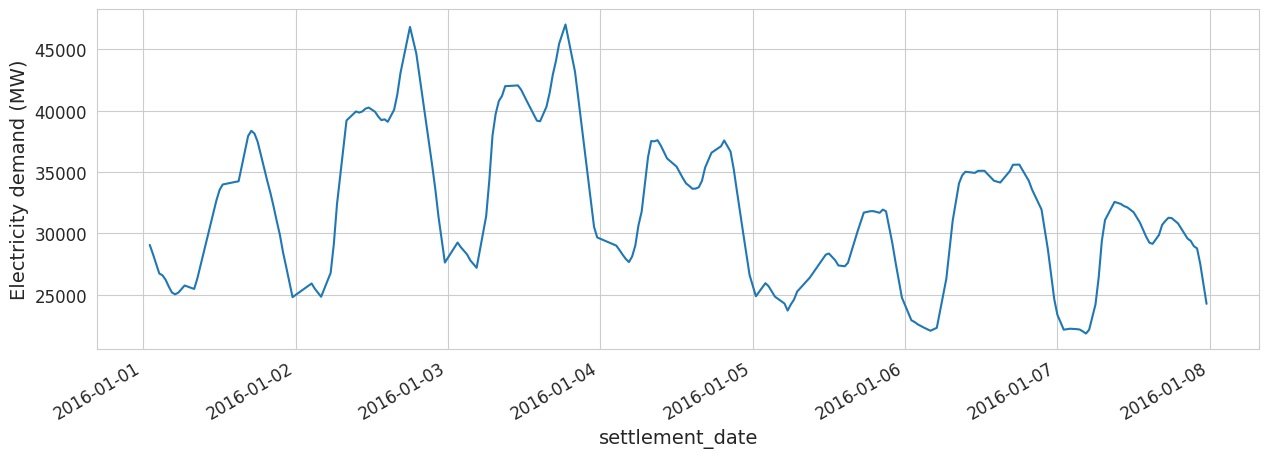

In [37]:
#The `settlement_date` column is now in the right format to use an index:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [38]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [39]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

settlement_period period_hour     nd    tsd  demand  \
settlement_date                                                            
2013-04-13 07:00:00                 15     7:00:00  31304  31939   28064   
2017-08-20 21:30:00                 44    21:30:00  28581  29086   25780   
2014-02-28 22:00:00                 45    22:00:00  36478  37765   33200   
2018-06-16 07:30:00                 16     7:30:00  23944  24452   22099   
2020-11-02 15:30:00                 32    15:30:00  37280  37890   34173   

                     embedded_wind_generation  embedded_wind_capacity  \
settlement_date                                                         
2013-04-13 07:00:00                       172                    1995   
2017-08-20 21:30:00                       545                    5305   
2014-02-28 22:00:00                       362                    2524   
2018-06-16 07:30:00                      1253                    5859   
2020-11-02 15:30:00                      5145                    6465   

                     embedded_solar_generation  embedded_solar_capacity  \
settlement_date                                                           
2013-04-13 07:00:00                        150                     2623   
2017-08-20 21:30:00                          0                    12372   
2014-02-28 22:00:00                          0                     4442   
2018-06-16 07:30:00                       1440                    13052   
2020-11-02 15:30:00                       1580                    13080   

                     non_bm_stor  ...  day_of_month  day_of_week  day_of_year  \
settlement_date                   ...                                           
2013-04-13 07:00:00            0  ...            13            5          103   
2017-08-20 21:30:00            0  ...            20            6          232   
2014-02-28 22:00:00            0  ...            28            4           59   
2018-06-16 07:30:00            0  ...            16            5          167   
2020-11-02 15:30:00            0  ...             2            0          307   

                     quarter  month  year  week_of_year     lag1     lag2  \
settlement_date                                                             
2013-04-13 07:00:00        2      4  2013            15      NaN  29203.0   
2017-08-20 21:30:00        3      8  2017            33      NaN      NaN   
2014-02-28 22:00:00        1      2  2014             9  37261.0  43537.0   
2018-06-16 07:30:00        2      6  2018            24      NaN  25410.0   
2020-11-02 15:30:00        4     11  2020            45      NaN  28944.0   

                        lag3  
settlement_date               
2013-04-13 07:00:00  30038.0  
2017-08-20 21:30:00      NaN  
2014-02-28 22:00:00  34330.0  
2018-06-16 07:30:00      NaN  
2020-11-02 15:30:00  21667.0  

[5 rows x 31 columns]

## Feature understanding¶

In this section, I will explore the distribution of electricity demand with respect the different features, such as as hour, month or year. This is a great way to understand the seasonalities in the time series.


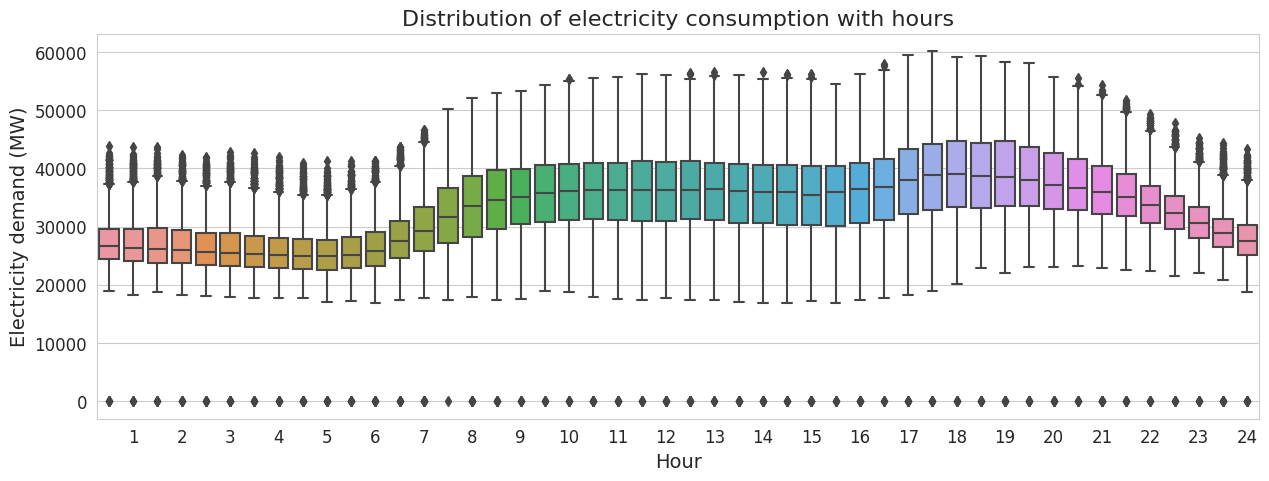

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

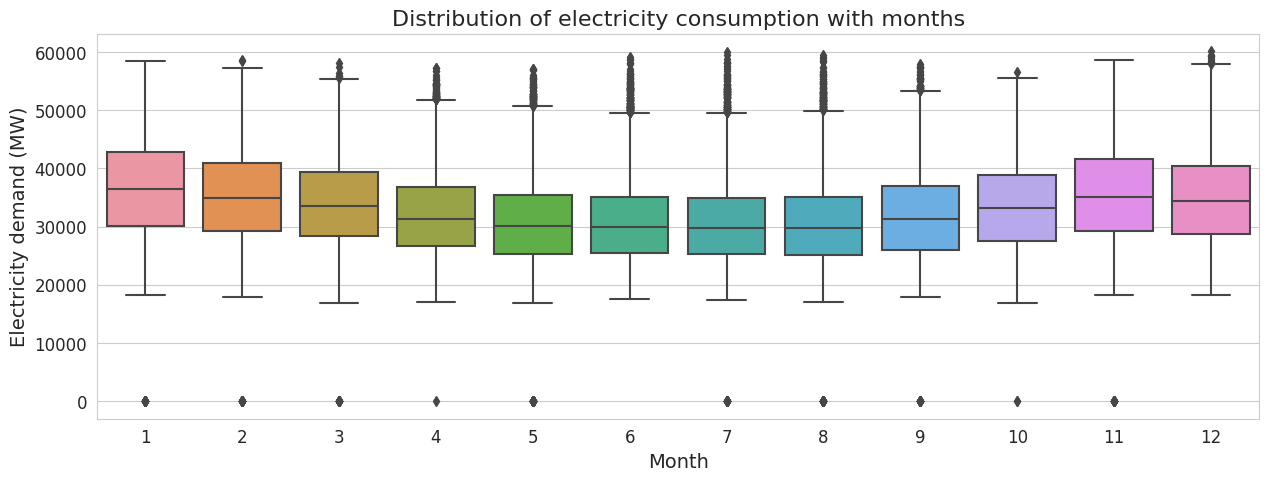

In [41]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

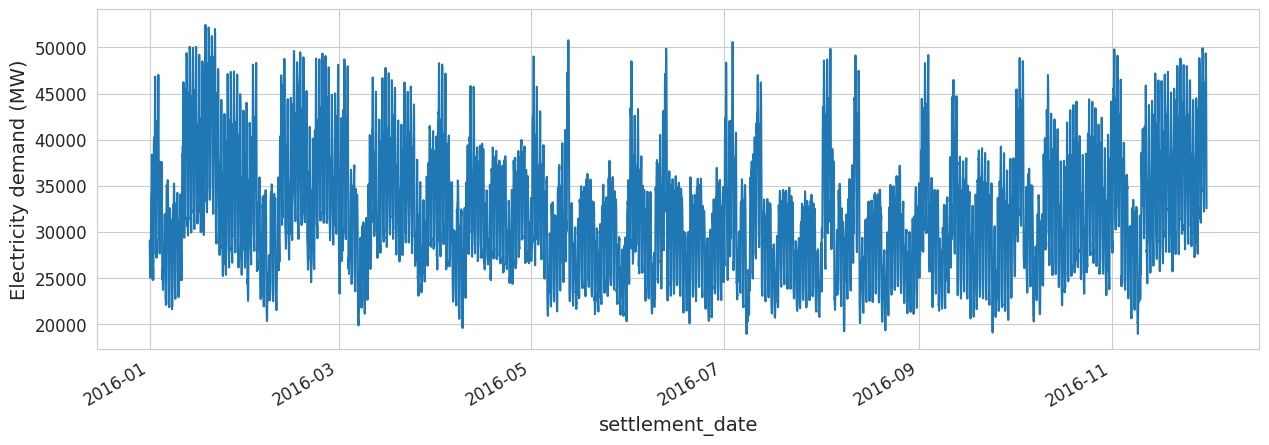

In [42]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

Let's look at the effect of bank holidays on electricity consumption

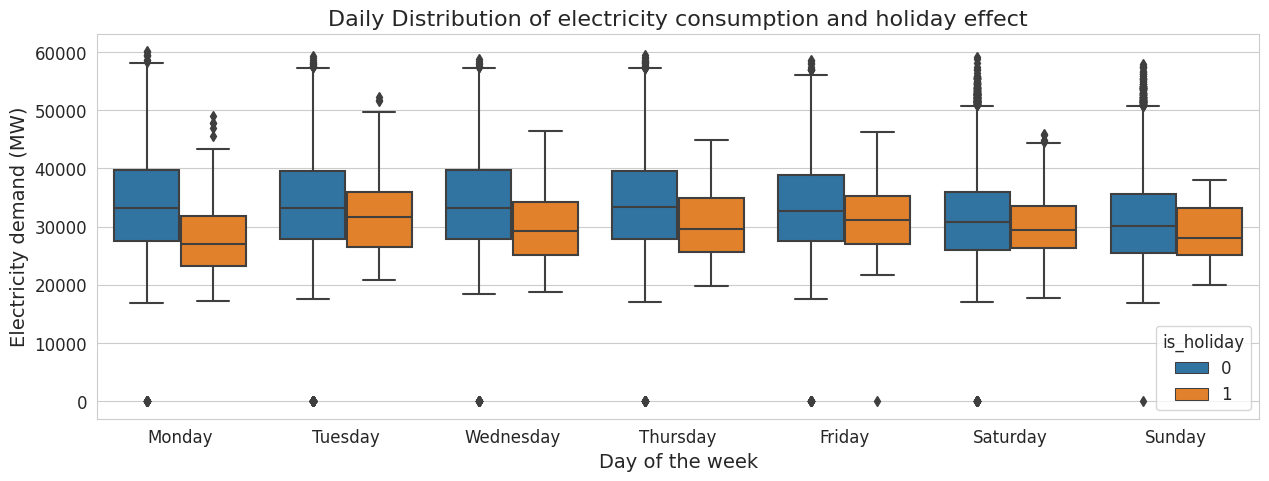

In [43]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

It appears that from Monday to Friday, bank holidays typically see lower electricity consumption, while Saturdays show an increase, and Sundays remain unaffected. For non-bank holidays, weekend demand is lower than on weekdays.


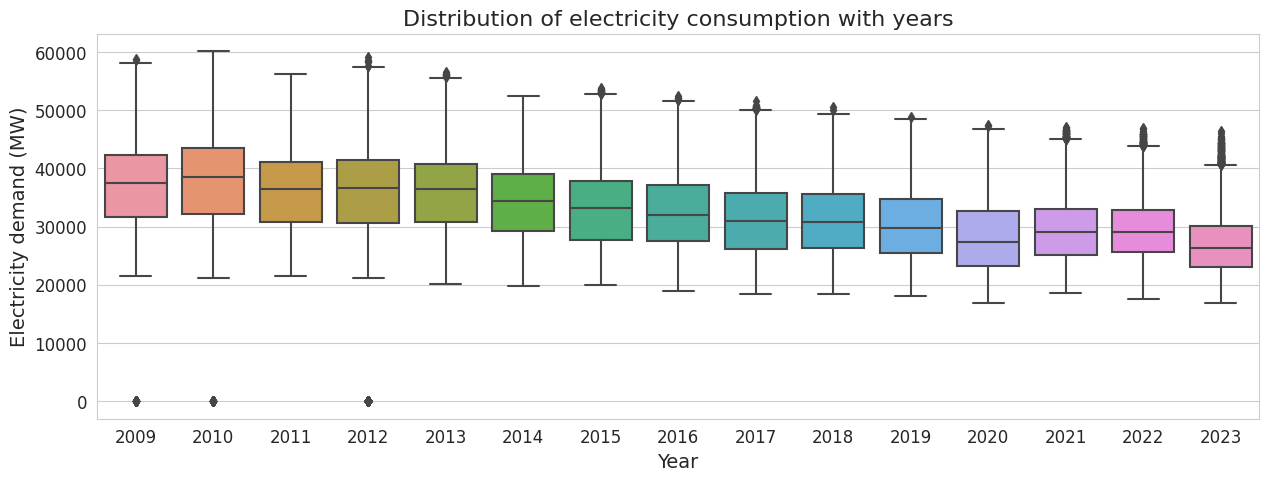

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

These yearly averages reveal a decreasing trend in electricity usage. By layering the consumption data for two distinct years, we can ascertain their comparative patterns.


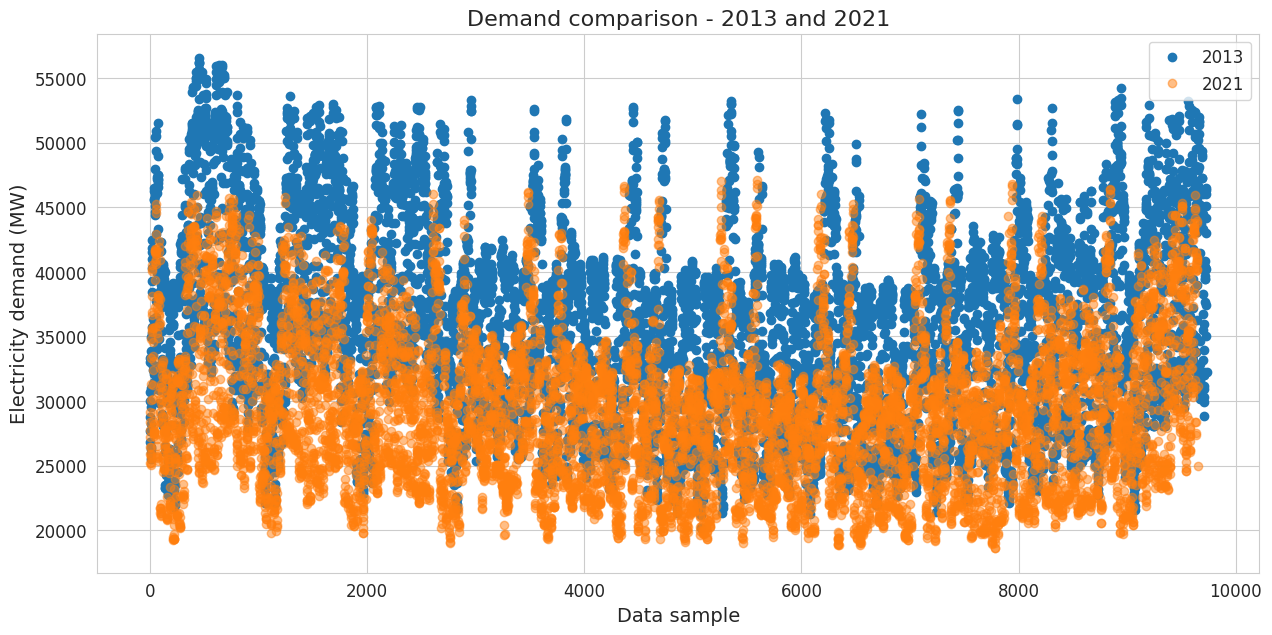

In [45]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

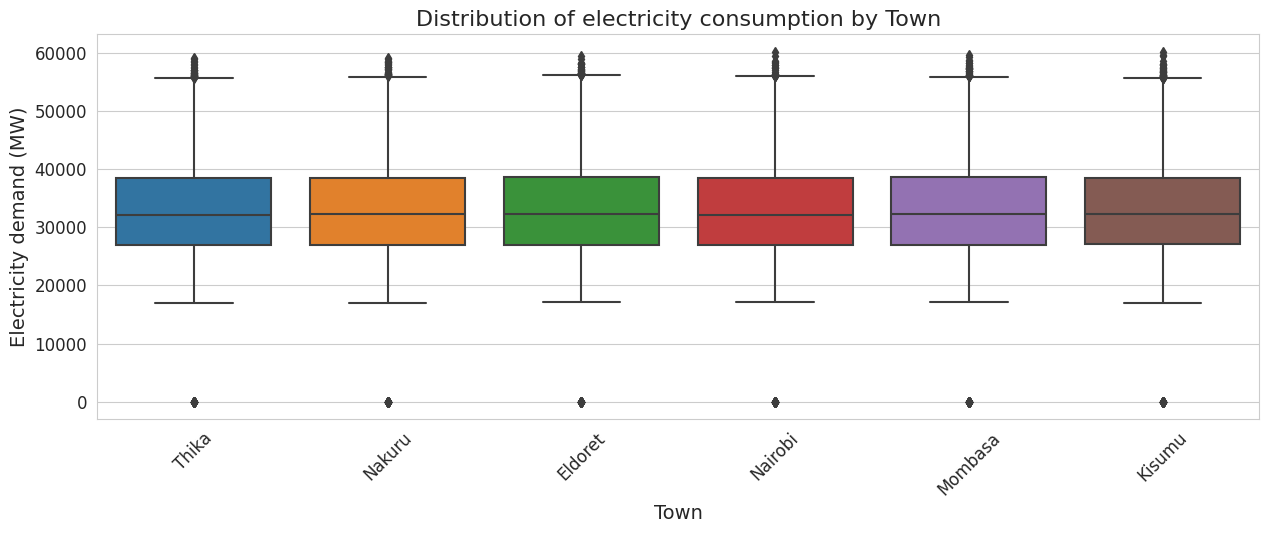

In [46]:
# Set the figure size
fig, ax = plt.subplots(figsize=(15, 5))

# Create the boxplot for towns and electricity demand
sns.boxplot(x="town", y="tsd", data=df)

# Set labels and title
ax.set_xlabel("Town")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption by Town")

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

## Time-series models

Once I've gained enough understanding of the time series data, I'm ready to create different models and check their accuracy on the predictions. In order to compare the results of the models, I will use the Mean Absolute Percentage Error, which I implemented as follows


In [48]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

##SARIMA¶

SARIMA is the first time series forecasting method I will use to predict the electricity demand. I expect this model to perform worse than other methods as there are multiple seasonalitites in the data: daily, weekly and yearly.

In fact, in order to get a decent result, I had to reduce the frequency of the data from twice an hour to daily data. This is nothing but smoothing (filtering) the data and removing what is essentially "noise" in a long time series. My goal is to understand how to tweak the model parameters using autocorrelation plots to increase the accuracy of the model.
##SARIMA data

The first step to create a SARIMA model is to modify the time series data. I will reduce the frequency of the data to daily summed samples. The reason to use the summed values instead of mean values is that we might see a spike at certain hours of the day that might be masked by the average, whereas summed valuers will show this.


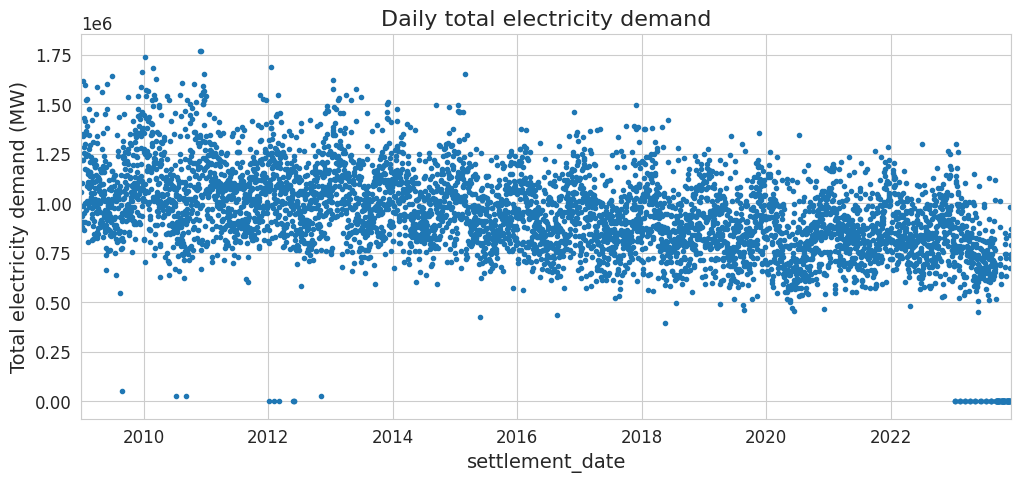

In [49]:
df_sarima = df["tsd"].resample("D").sum().to_frame()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

We can see that the number of samples has been reduced, but most importantly, there are values equal to 0. These values are related to the original nan values that were replaced before. While the data for the days containing at least one nan value were removed, re-sampling the data using a daily frequency leads to pandas creating those days again and assigning a value equal to 0. I will replace those values using the mean monthly value for that year.

In [54]:
df_sarima["lag_day"] = df_sarima["tsd"].shift(1)
df_sarima["lag_year"] = df_sarima["tsd"].shift(364)


df_sarima["difference_day"] = df_sarima["tsd"] - df_sarima["lag_day"]
df_sarima["difference_year"] = df_sarima["tsd"] - df_sarima["lag_year"]

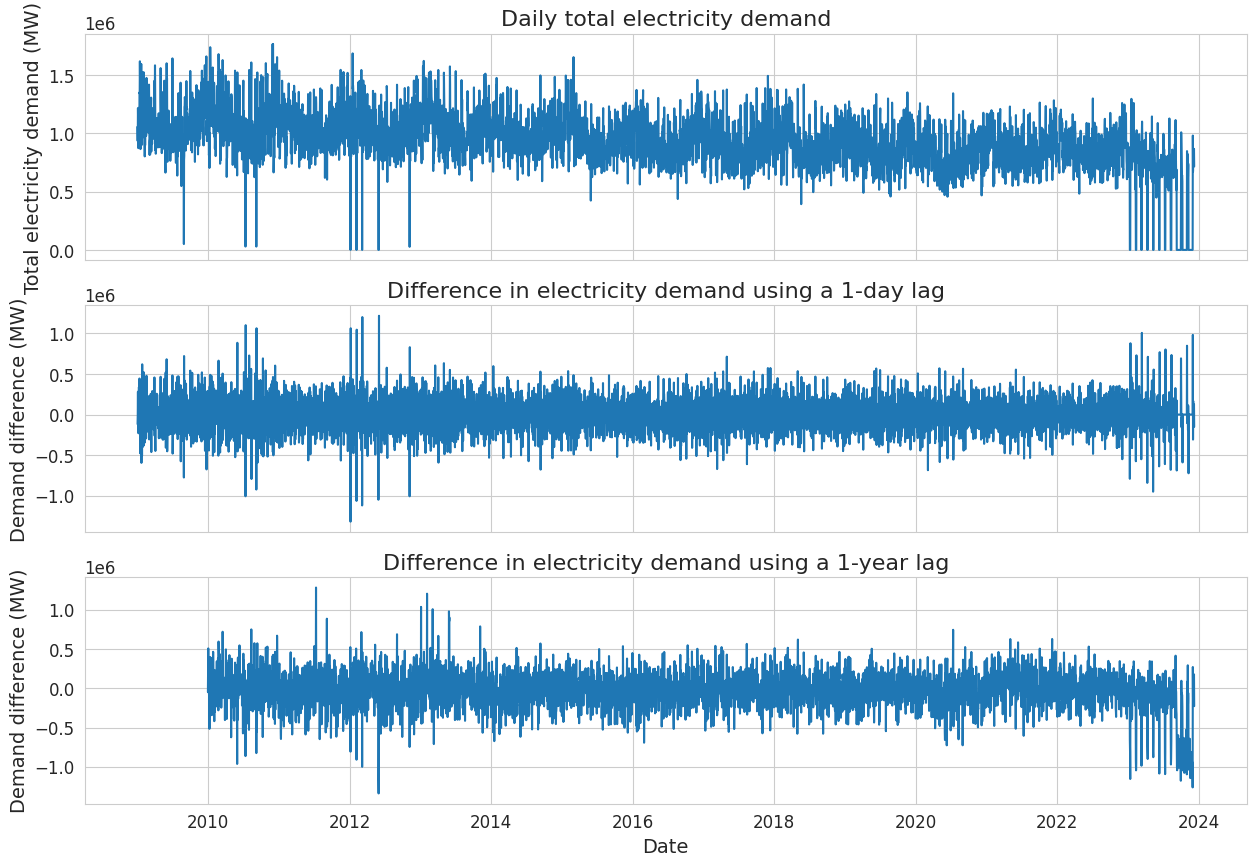

In [55]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes.ravel()
axes[0].plot(df_sarima.index, df_sarima["tsd"])
axes[0].set_ylabel("Total electricity demand (MW)")
axes[0].set_title("Daily total electricity demand")
axes[1].plot(df_sarima.index, df_sarima["difference_day"])
axes[1].set_ylabel("Demand difference (MW)")
axes[1].set_title("Difference in electricity demand using a 1-day lag")
axes[2].plot(df_sarima.index, df_sarima["difference_year"])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand difference (MW)")
axes[2].set_title("Difference in electricity demand using a 1-year lag");

I personally cannot see the autocorrelation patterns given the number of samples in a 12-inch long plot, but this will be tackled in the next section.


##EDA SARIMA data and SARIMA parameter estimation

In this section, I perform EDA specifically focused on the SARIMA model aiming at determining the model parameters. I will assess the stationarity of the series, difference the data using 1-day and 1-year lags and check for estationarity again to determine d and D, and create autocorrelation plots to determine p,d,P and Q. These ideas are described in more depth in two Medium articles (article 1 and article 2).

The next cell includes the functions I created to perform the above functions, but I've hidden it because it's quite long. Feel free to check it yourself!


In [57]:
def dftest(timeseries, window_size):
    """
    Perform ADFuller test, report the results and plot rolling statistics

    Args:
        - timeseries: time series data
        - window_size: window size for rolling statistics
    """
    dftest = sm.stattools.adfuller(
        timeseries,
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid(True)
    plt.show(block=False)


def autocorr_plots(data, lags=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot

    Args:
        - data: time series data
        - lags: number of lags for the autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags, ax=acf, zero=True)
    sm.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()


def autocorr_plots_dual_lags(data, lags_1=None, lags_2=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot
    using two lags

    Args:
        - data: time series data
        - lags_1: number of lags for first set of autocorrelation plots
            Default value is None
        - lags_2: number of lags for first set of autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 14))
    layout = (5, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf_1 = plt.subplot2grid(layout, (1, 0))
    pacf_1 = plt.subplot2grid(layout, (2, 0))
    acf_2 = plt.subplot2grid(layout, (3, 0))
    pacf_2 = plt.subplot2grid(layout, (4, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags_1, ax=acf_1, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_1, ax=pacf_1, zero=True, method="ywm")
    sm.graphics.plot_acf(data, lags=lags_2, ax=acf_2, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_2, ax=pacf_2, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

One can begin by checking the results from the ADF test:


Test Statistic            -1.210157
p-value                    0.669211
Lags Used                 30.000000
Observations Used       5424.000000
Critical Value (1%)       -3.431556
Critical Value (5%)       -2.862073
Critical Value (10%)      -2.567054
dtype: float64


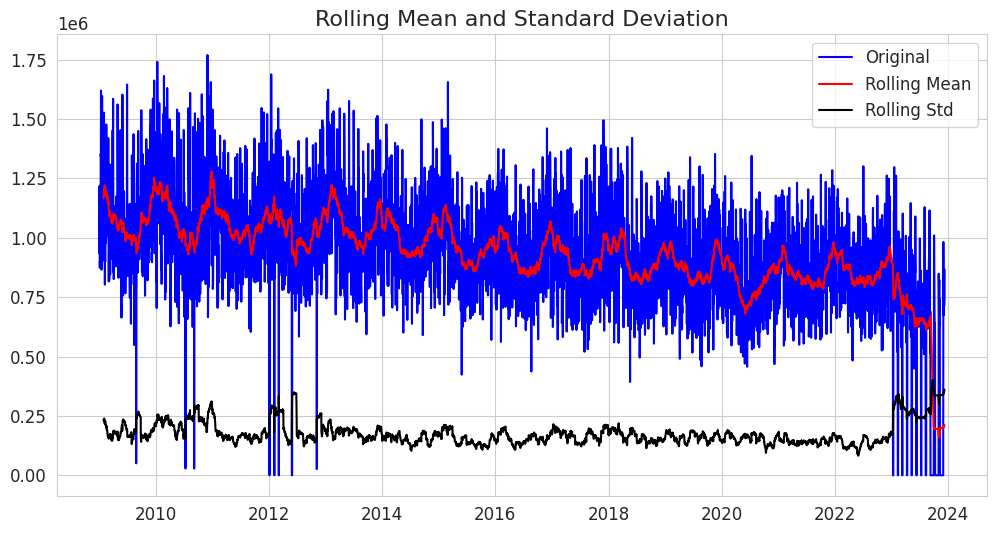

In [58]:
dftest(df_sarima["tsd"], 30)

According to the test statistics and the p-value, the time series is stationary, but we can see that it doesn't meet the requirements of a stationary series as the series shows seasonality and a decreasing trend.

Let's try lookinf at the 1-day differenced data:


Test Statistic           -34.883135
p-value                    0.000000
Lags Used                 29.000000
Observations Used       5424.000000
Critical Value (1%)       -3.431556
Critical Value (5%)       -2.862073
Critical Value (10%)      -2.567054
dtype: float64


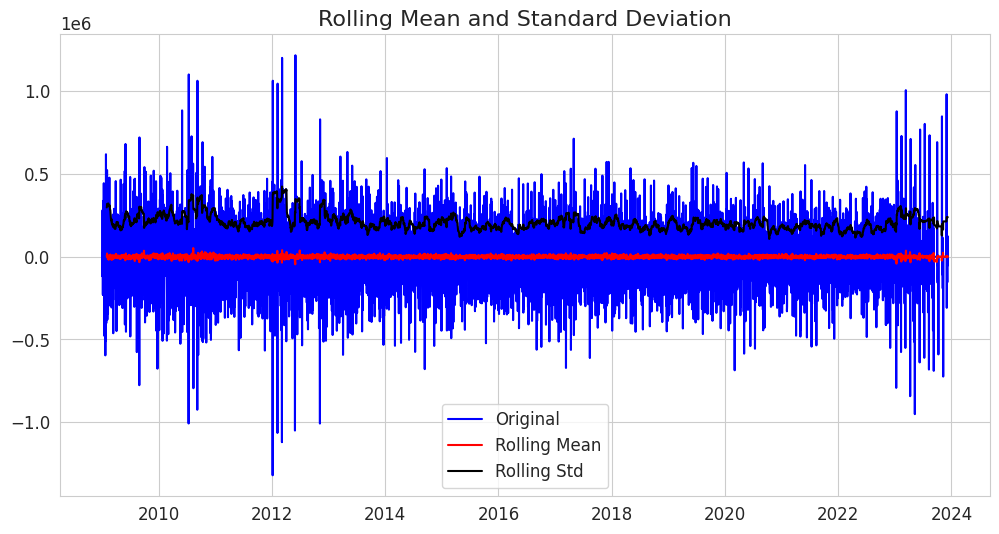

In [59]:
dftest(df_sarima["difference_day"].dropna(), 30)

Since the data is now stationary, we can use d=1 in the model.

To determine D, we need to isolate the seasonal component of the series. To do so, the first step is to decompose the series, which is straightforward since the series is additive


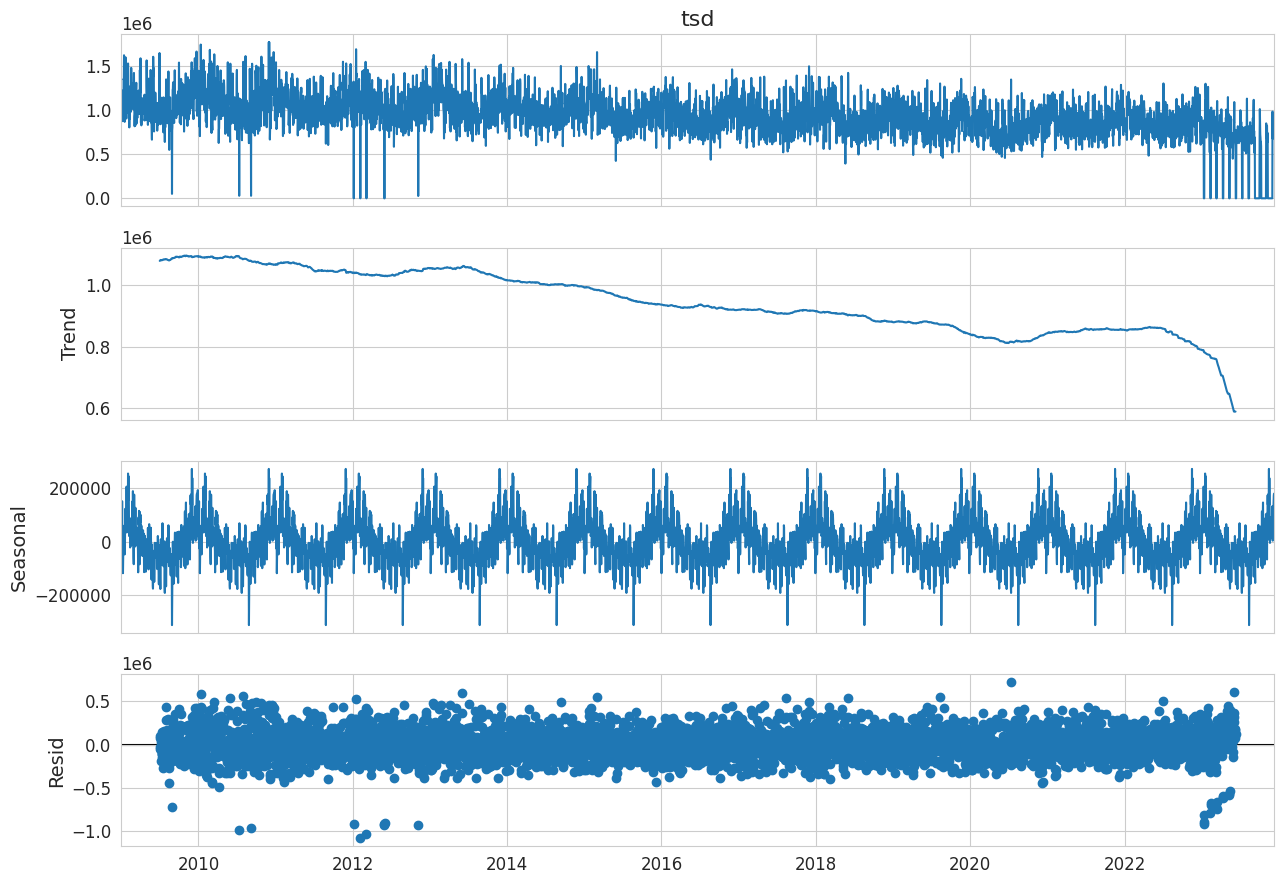

In [60]:
decompose = sm.seasonal_decompose(df_sarima["tsd"].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches((13, 9))
fig.tight_layout()

Once the seasonal component is isolated, we can check if its' stationary


Test Statistic            -4.117969
p-value                    0.000904
Lags Used                 33.000000
Observations Used       5421.000000
Critical Value (1%)       -3.431557
Critical Value (5%)       -2.862073
Critical Value (10%)      -2.567054
dtype: float64


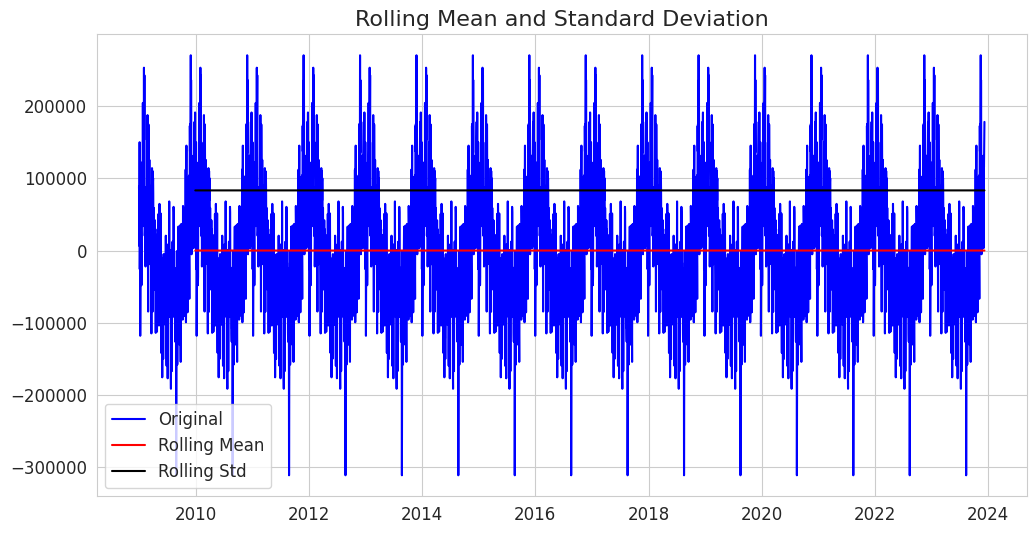

In [61]:
dftest(decompose.seasonal, 364)

Similarly to the first ADF test, the test results suggest that the data is stationary, but since this is seasonal data, it is by definition non-stationary. Let's look at the 1-year lag data:


Test Statistic            -2.981615
p-value                    0.036647
Lags Used                 30.000000
Observations Used       5060.000000
Critical Value (1%)       -3.431643
Critical Value (5%)       -2.862111
Critical Value (10%)      -2.567074
dtype: float64


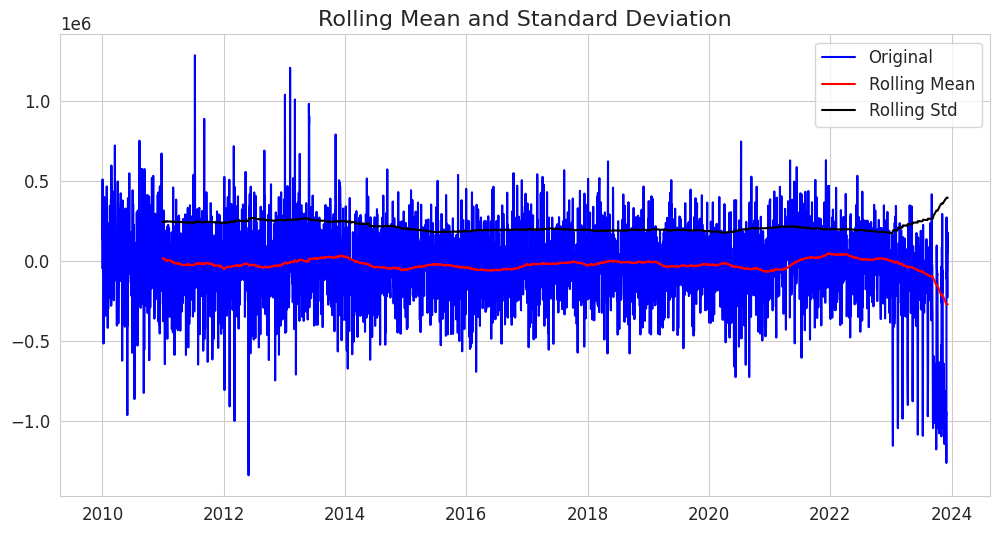

In [62]:
dftest(df_sarima["difference_year"].dropna(), 364)

Since the 1-year differenced data is stationary, D=1.

To determine p and q, one can analyse the autocorrelation plots of the original data:


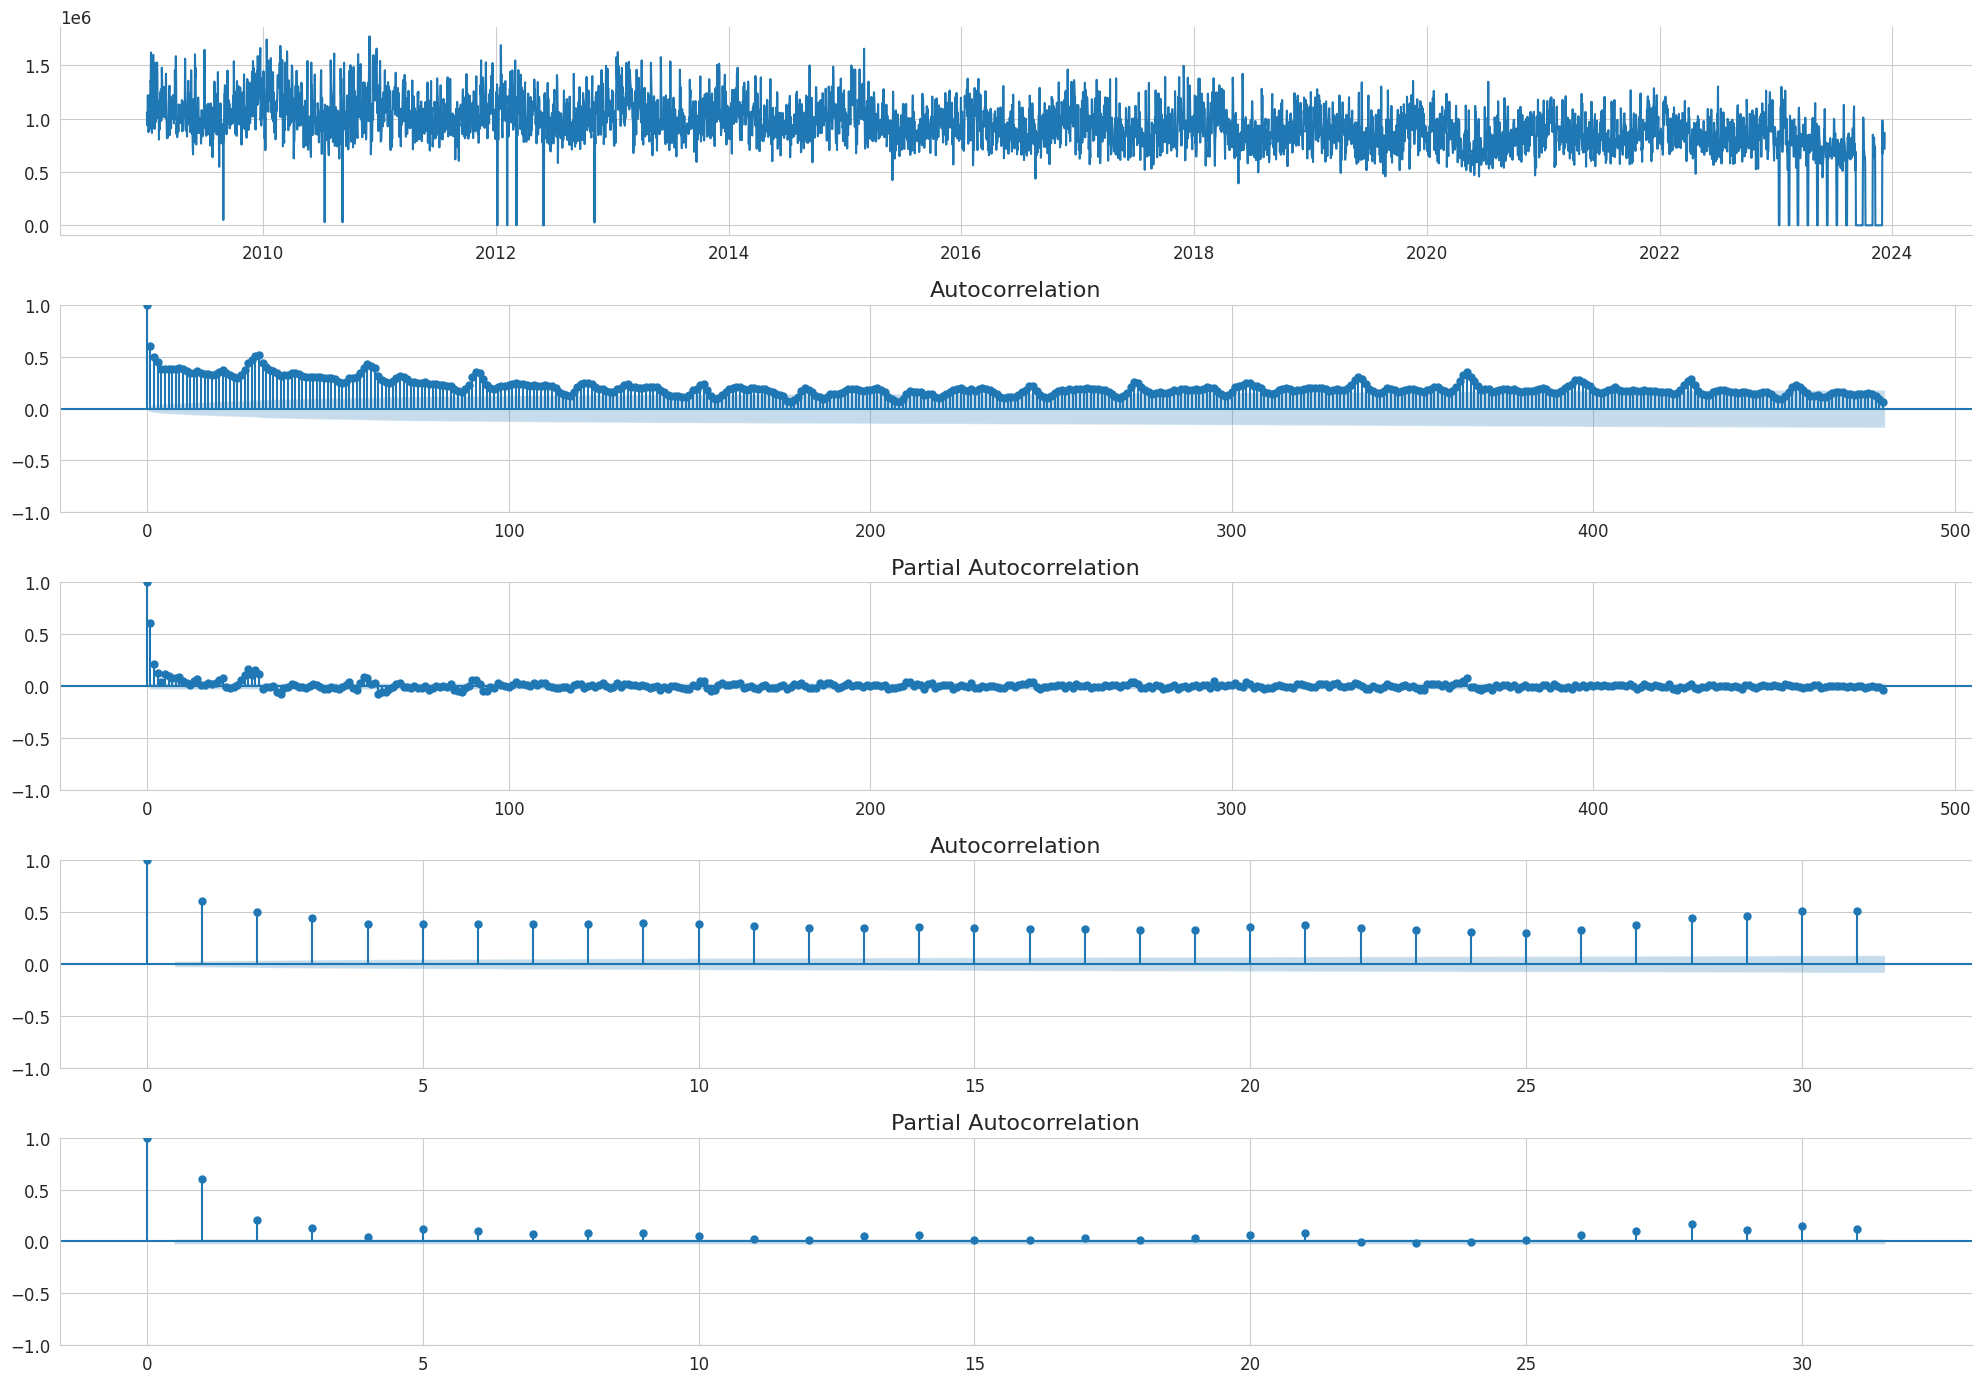

In [63]:
autocorr_plots_dual_lags(df_sarima["tsd"], lags_1=480, lags_2=31)

From this plot we can see that there is a clear yearly seasonality, but there is also a weekly seasonality. Unfortunately, the autocorrelation values don't fall within the condifence interval until around lag 120 and the partial autocorrelation values don't reach the confidence interval continously and there are multiple spikes.

Good starting values for the AR and MA parameters are p=7 and q=2.

We can use the 1-year differenced values to estimate the seasonal parameters:


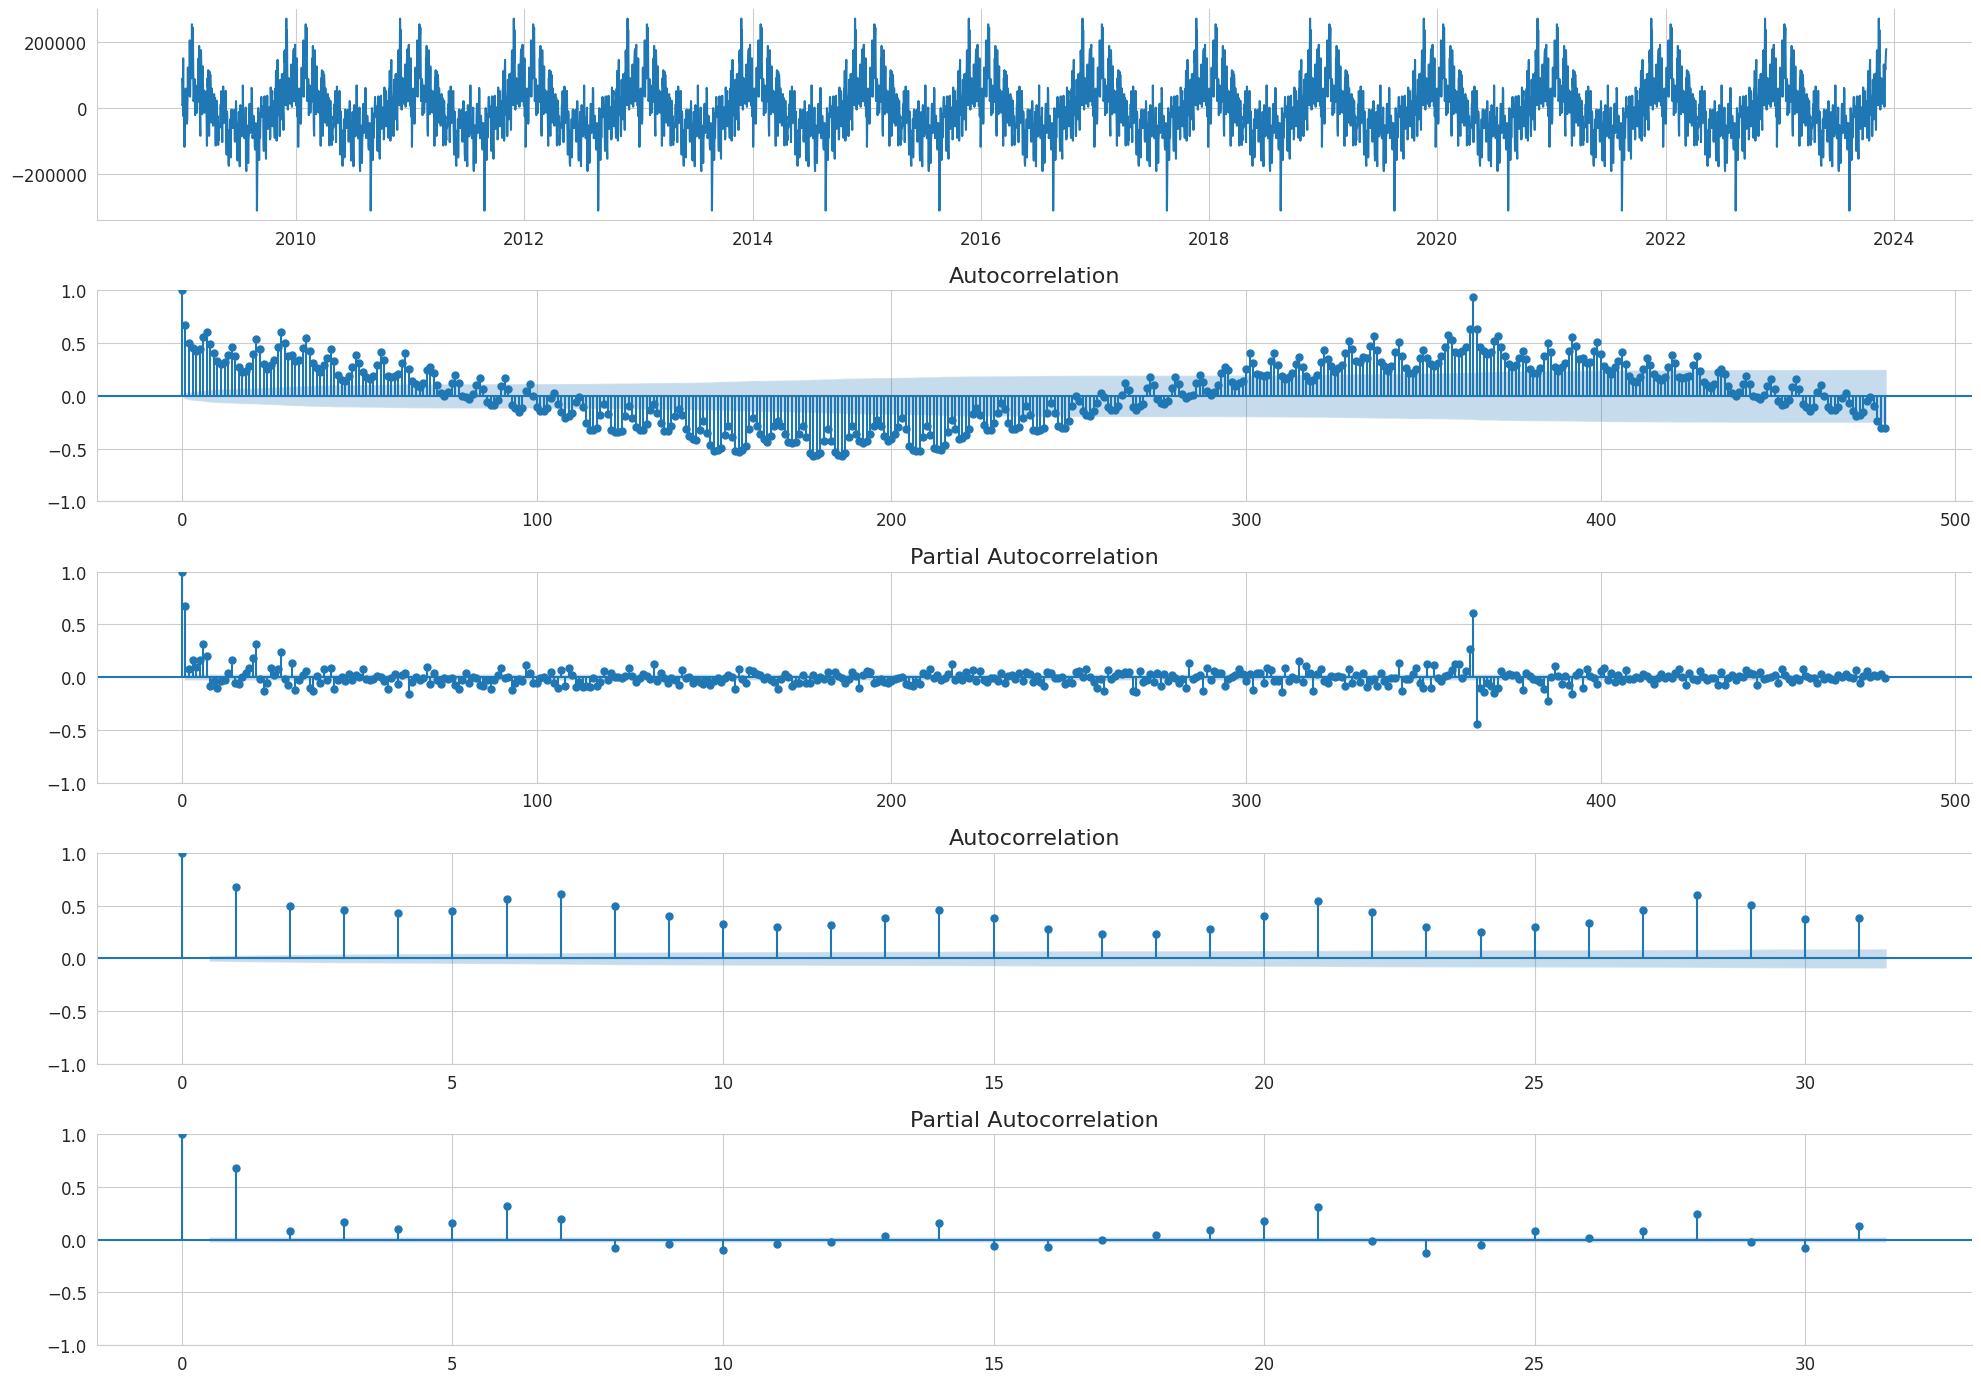

In [64]:
autocorr_plots_dual_lags(decompose.seasonal, lags_1=480, lags_2=31)

ual_lags(decompose.seasonal, lags_1=480, lags_2=31)

These graphs show the same issues since the values either take many lags to fall within the confidence interval or they never do it continuously. A good first estimation is P=3, Q=2 and M=12.

I know that Q should be higher, but as we will see, as I increase the values of the parameters it takes way longer to train the model as there are more parameters to compute. At first, I want a reasonable estimation that doesn't take very long to run.

##Train-test split

In [65]:
threshold_date = "01-01-2021"
train_data = df_sarima.loc[df_sarima.index < threshold_date, "tsd"]
test_data = df_sarima.loc[df_sarima.index >= threshold_date, "tsd"]

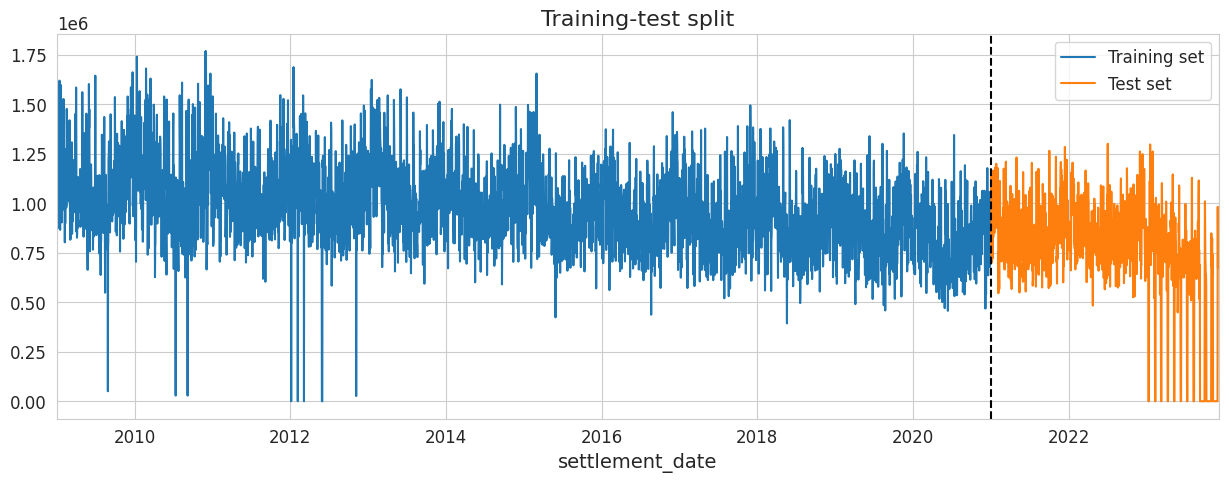

In [66]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label="Training set")
test_data.plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend();

##Model 0 - baseline

In order to assess the quality of the SARIMA models, I will first create a very simple model with p, q, P and Q values equal to 1 and compute the error. This will be ussed to measure how much the models improve as we tune the parameters.

I will use some functions to create the model, compute statistical tests and generate predictions. I've hidden the next kernel cell because it's quite long, but feel free to check it!


In [67]:
def stats_test(sar_model):
    """
    Perform statistical tests on SARIMA model and print the results

    Args:
        - sar_model: SARIMA model
    """

    # create and run statistical tests on model
    norm_val, norm_p, skew, kurtosis = sar_model.test_normality("jarquebera")[0]
    lb_val, lb_p = sar_model.test_serial_correlation(
        method="ljungbox",
    )[0]
    het_val, het_p = sar_model.test_heteroskedasticity("breakvar")[0]

    # we want to look at largest lag for Ljung-Box, so take largest number in series
    # there's intelligence in the method to determine how many lags back to calculate this stat
    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    durbin_watson = statsmodels.stats.stattools.durbin_watson(
        sar_model.filter_results.standardized_forecasts_error[
            0, sar_model.loglikelihood_burn :
        ]
    )

    print("Normality: val={:.3f}, p={:.3f}".format(norm_val, norm_p))
    print("Ljung-Box: val={:.3f}, p={:.3f}".format(lb_val, lb_p))
    print("Heteroskedasticity: val={:.3f}, p={:.3f}".format(het_val, het_p))
    print("Durbin-Watson: d={:.2f}".format(durbin_watson))


def create_predict_analyse(
    timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag
):
    """
    Create SARIMA model and perform the following actions:
        - Perform statisticals tests to check if the model parameters are right
        - Plot model diagnostics
        - Predict on test data
        - Compute MAPE
        - Plot test data, prediction and confidence interval

    Args:
        - timeseries: time series data
        - order: SARIMA order parameters
        - seasonal_order: SARIMA seasonal order parameters
        - max_iter: maximum number of iterations to compute SARIMA values
        - lags: number of lags used for model diagnostics
        - test_data: test data
        - disp_flag: boolean variable to display SARIMA model iterations

    Returns:
        - execution_time: SARIMA model runtime
        - mape: MAPE on test data
        - sarima_model: SARIMA model created using the function arguments
    """

    # Create and fit SARIMA model
    start_time = datetime.datetime.now()
    sarima_model = sm.statespace.SARIMAX(
        timeseries, order=order, seasonal_order=seasonal_order
    ).fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.datetime.now() - start_time

    # Perform statistical tests on model
    stats_test(sarima_model)
    print("-------------------------------------------------------------")

    # Plot SARIMA model diagnostics
    sarima_model.plot_diagnostics(
        lags=lags,
        figsize=(20, 12),
    )

    # Predict on test data
    predict = sarima_model.get_prediction(
        start="01-01-2021", end=str(test_data.index[-1].date())
    )
    confidence_int = predict.conf_int(alpha=0.05)
    prediction = predict.predicted_mean

    # Calculate MAPE on test data
    mape = mean_absolute_percentage_error(test_data.values, prediction.values)

    # Plot test data, predictions and confidence interval
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(prediction, label="Prediction")
    ax.plot(test_data, label="Test data")
    ax.fill_between(
        confidence_int.index,
        confidence_int["lower tsd"],
        confidence_int["upper tsd"],
        alpha=0.3,
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()

    return execution_time, mape, sarima_model

Normality: val=882.051, p=0.000
Ljung-Box: val=569.148, p=0.000
Heteroskedasticity: val=0.630, p=0.000
Durbin-Watson: d=1.50
-------------------------------------------------------------


<ipython-input-48-108627ed18d9>:15: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


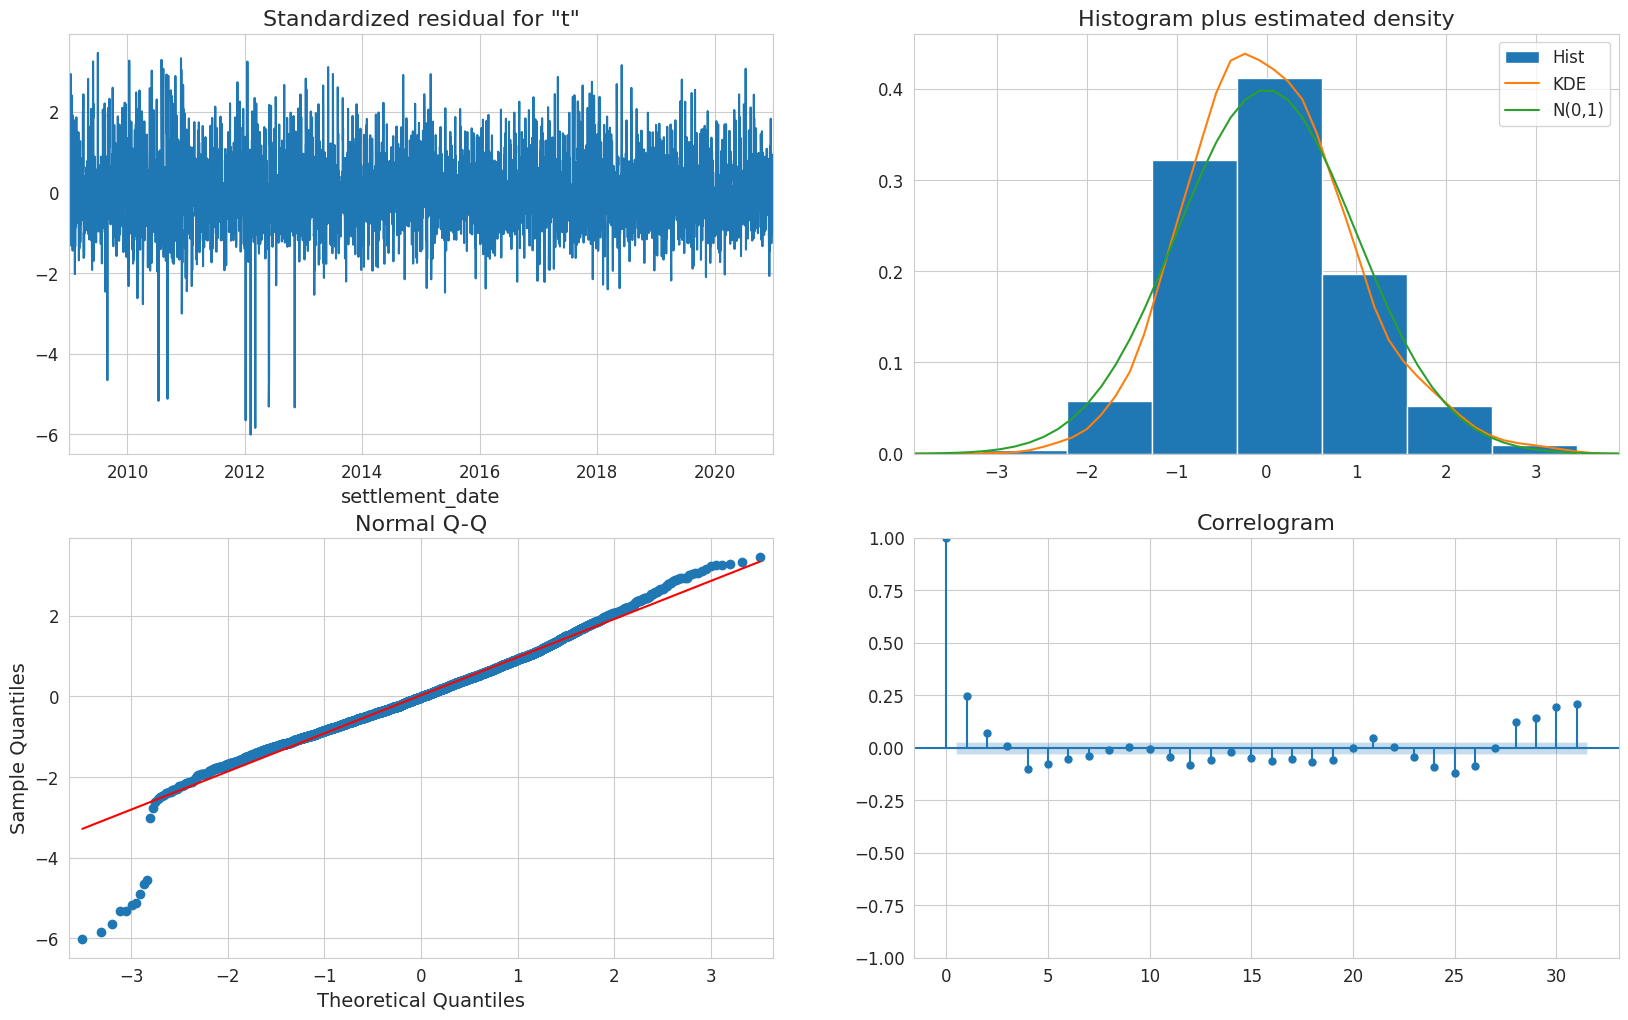

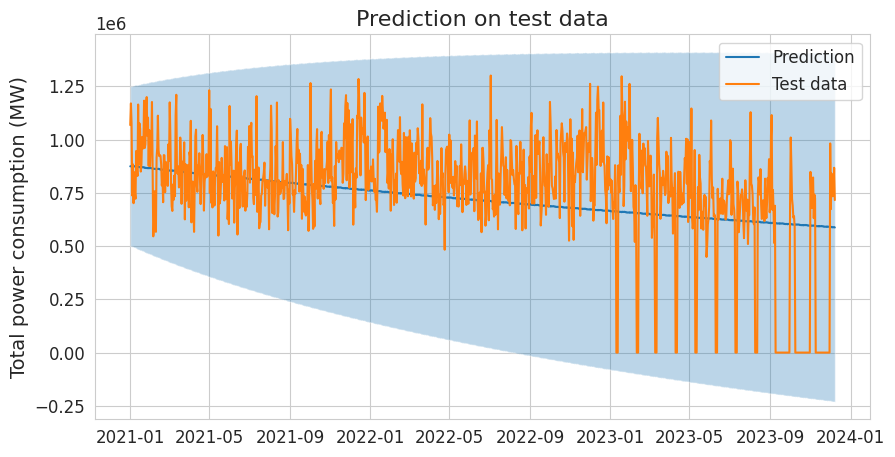

In [68]:
[execution_time_0, mape_0, sarima_model_0] = create_predict_analyse(
    train_data, (1, 0, 1), (1, 0, 1, 12), 75, 31, test_data, False
)

##Model 2

In the diagnostic plots above, it can be seen that there is a spike at lag 7 in the autocorrelation plot. Therefore, I will set q=7 and run the model again:


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Normality: val=1020.702, p=0.000
Ljung-Box: val=41.671, p=0.014
Heteroskedasticity: val=0.596, p=0.000
Durbin-Watson: d=2.03
-------------------------------------------------------------


<ipython-input-48-108627ed18d9>:15: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


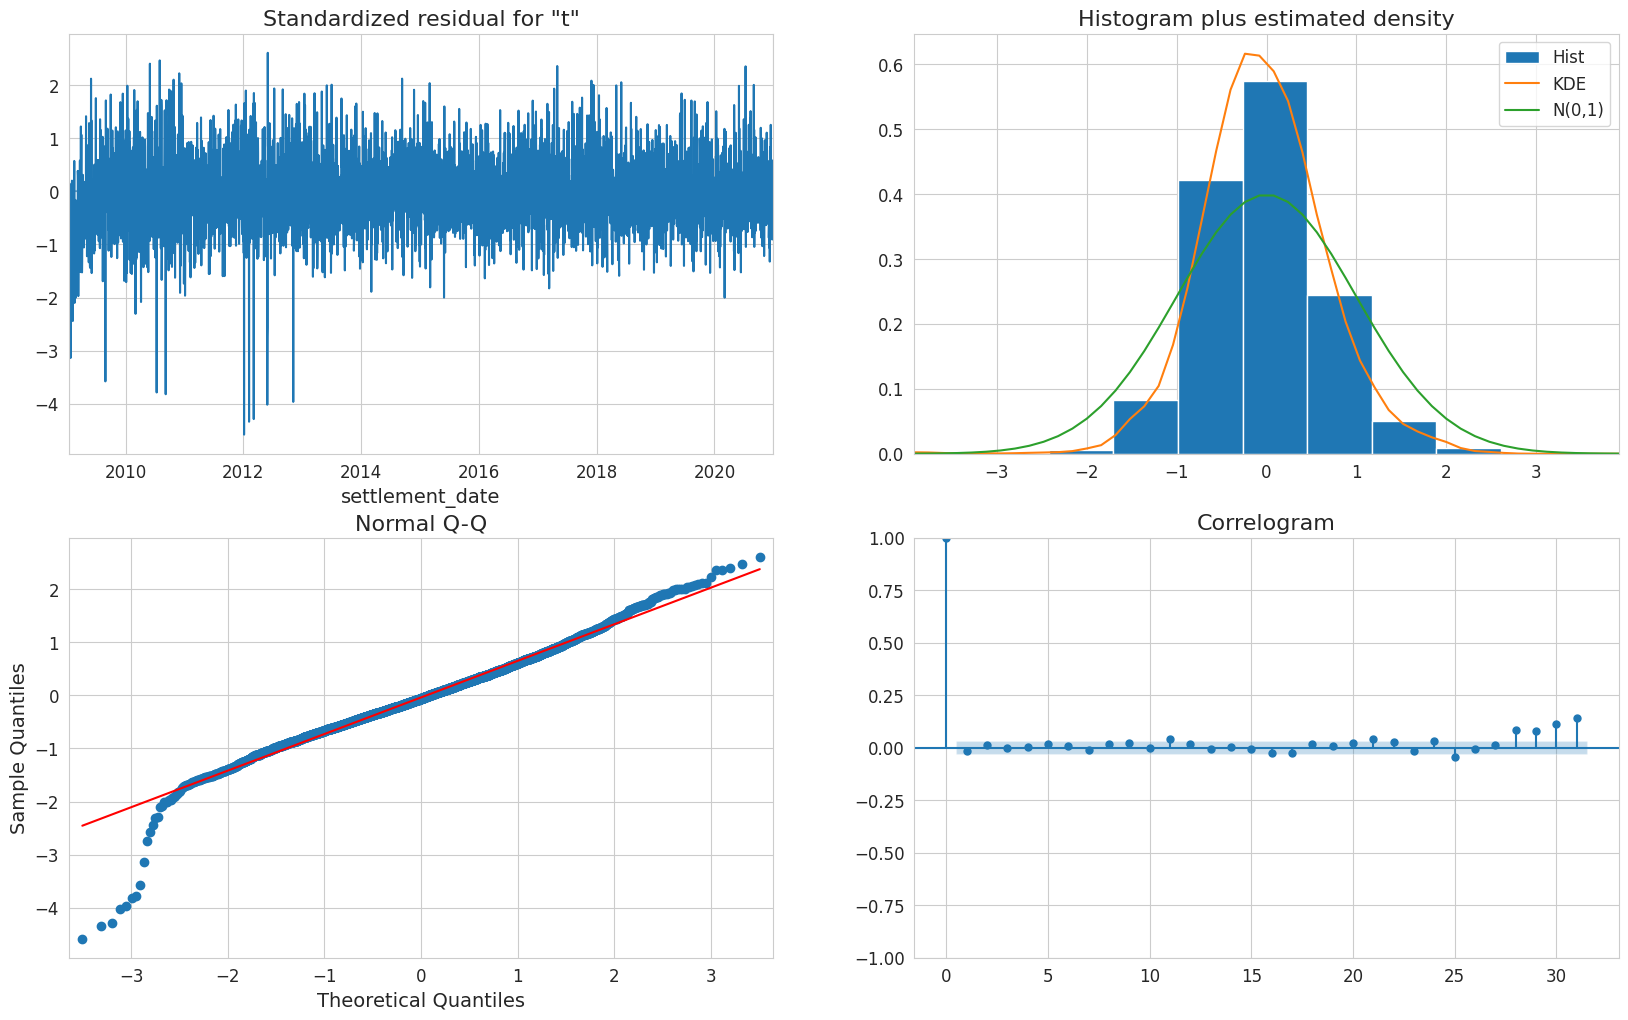

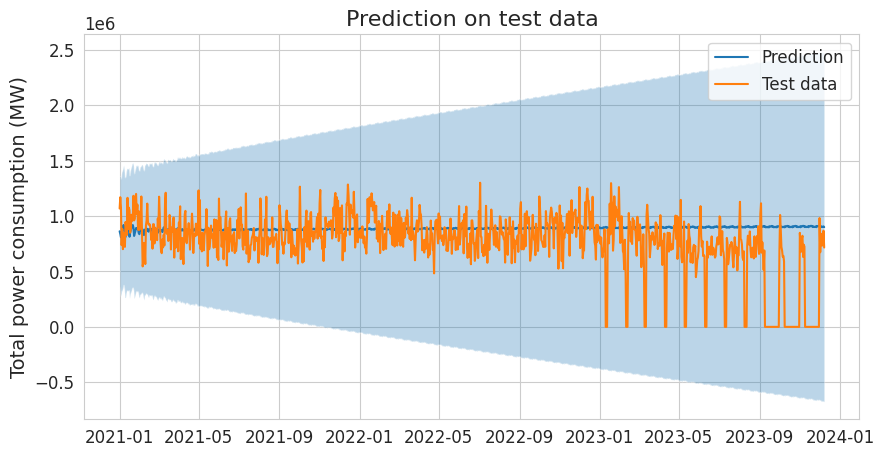

In [71]:
[execution_time_2, mape_2, sarima_model_2] = create_predict_analyse(
    train_data, (7, 1, 7), (3, 1, 2, 12), 50, 31, test_data, False
)

In [72]:
print(f"Model 0 MAPE value: {mape_2}")
print(f"Model 0 runtime: {execution_time_2}")

Model 0 MAPE value: inf
Model 0 runtime: 0:07:19.459835


The prediction has improved and it's barely 12% error, but the runtime has also increased. This is a concern since grid search isn't feasible for such long runtimes